
# **DATATHON UNIVERSITYHACK 2020**

## *Minsait Land Classification*

https://www.cajamardatalab.com/datathon-cajamar-universityhack-2020/retos/predictivo/

---

## Equipo ***Anacongas***
### Escuela Superior de Informática de Ciudad Real (UCLM)

> ![Logo](https://drive.google.com/uc?id=1j0Z02FzZDIuAJbZKvDe-84OE1az7O47r)


*   ### Antonio Manjavacas Lucas (Antonio.Manjavacas@alu.uclm.es)
*   ### Rubén Márquez Villalta (Ruben.Marquez@alu.uclm.es)
*   ### Diego Pedregal Hidalgo (Diego.Pedregal@alu.uclm.es)


Con este trabajo presentamos nuestra participación en el reto MINSAIT LAND CLASSIFICATION del Cajamar UniversityHack 2020. 

En esta edición, el desafío planteado es la elaboración de un modelo predictivo orientado a la clasificación automática de tipos de suelo en base a características catastrales y datos extraídos de imágenes vía satélite.





#1. **CARGA DE DATOS**

In [0]:
!pip install imbalanced-learn

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

from google.colab import drive

from tqdm.auto import tqdm

from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn import tree
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier

from scipy.stats import randint as sp_randint

from imblearn.under_sampling import NearMiss
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.ensemble import BalancedBaggingClassifier

from collections import Counter

from random import sample
from joblib import dump

/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.ensemble.bagging module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported fro

In [0]:
TRAIN_DATA_PATH = os.path.join('.', 'drive', 'My Drive', 'Universityhack', 'Data', 'Modelar_UH2020.txt')
PREDICT_DATA_PATH = os.path.join('.', 'drive', 'My Drive', 'Universityhack', 'Data', 'Estimar_UH2020.txt')

drive.mount('/content/drive')

df = pd.read_csv(TRAIN_DATA_PATH, index_col=0, sep='|')
df

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
35984B9C3E7CD9A1,2207357872,165920300,0.000000e+00,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,1572.003418,1943.686816,6512.787270,1.283357e-10,428.996347,574.000940,676.002960,778.003931,880.999176,997.000220,1130.001782,1311.997949,1626.996155,8627.098641,155.003632,402.000092,458.999939,510.000061,567.999939,632.000610,681.000916,726.109186,791.000269,902.999719,1980.172280,0.000013,892.016479,1244.014185,1497.998303,1731.204688,1944.003906,2160.996533,2410.995264,2719.999756,3180.000342,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0.0,2,RESIDENTIAL
F9D04BF6D037F8FB,2189757160,165463267,5.879611e-05,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,1505.990771,1804.993469,6269.935600,1.352518e-11,433.998392,565.000110,662.996521,746.001318,828.998413,912.000330,1011.997162,1142.202637,1384.994580,5357.790999,120.000275,419.000000,472.999939,509.999808,541.999976,572.000000,602.999939,636.000122,673.000122,745.000000,3647.195402,0.000030,846.002728,1139.006982,1363.993860,1558.000513,1749.993713,1956.000464,2194.001978,2507.001416,3012.991675,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1.0,8,RESIDENTIAL
B89D5711AFF8C423,2240147335,165690752,0.000000e+00,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,1375.008179,1719.003235,5010.767611,0.000000e+00,379.001587,507.003815,600.000519,684.000488,768.997528,867.001587,992.991760,1165.998413,1443.000366,5240.232771,83.000389,363.000031,429.002502,473.000015,510.000092,549.000244,590.999939,635.999817,692.999817,796.498779,1947.739721,0.000005,807.001373,1124.002441,1365.009583,1570.995117,1768.992798,1978.989258,2228.999146,2561.999756,3088.000488,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1.0,5,RESIDENTIAL
1C3478AC1522E7E4,2227146459,165934099,0.000000e+00,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,1136.997144,1447.997290,5465.430281,6.341585e-06,310.999088,405.998712,485.000607,558.997925,641.001007,731.994189,838.004376,974.797485,1217.996167,5343.168796,0.001450,256.999487,295.999969,329.000092,366.000043,411.000549,457.000061,506.000000,565.999817,663.999817,1424.396092,0.002285,1200.994470,1476.001294,1678.005042,1848.001782,2022.988464,2211.993506,2433.003687,2740.996582,3349.986328,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1.0,2,RESIDENTIAL
4D12AA5009064345,2212350459,165681791,0.000000e+00,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,1401.000488,1756.994141,7376.529218,0.000000e+00,284.000534,421.002472,526.003815,618.998779,705.999268,801.005432,912.999451,1069.996094,1348.497314,7460.394534,193.000626,431.505035,462.999939,492.000061,519.000427,547.000061,578.999878,617.999603,662.999939,750.000488,1940.403140,0.000000,529.004425,790.996704,999.001617,1183.995239,1355.992920,1535.998779,1725.498962,1954.991455,2315.991455,7092.767616,1789.873366,0.458819,0.012858,0.019936,1.550478,1966,8.0,6,RESIDENTIAL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
C5FD596EB22DB167,2225843339,165482267,2.183254e-11,427.999246,604.004626,742.996454,866.005859,990

#2. **LIMPIEZA DE DATOS**

A la hora de abordar el desafío, inicialmente se realizó un análisis de los datos, estudiando tanto su naturaleza como su distribución. 

Algunas conclusiones obtenidas tras este análisis inicial de los datos fueron las siguientes:

> **1)** Baja cantidad de registros nulos.

> **2)** Gran desbalanceo en el número clases presentes en el dataset, especialmente entre registros RESIDENCIALES y NO RESIDENCIALES, con una amplia mayoría de RESIDENCIALES, hecho que condicionaría nuestra forma de abordar el reto.

> **3)** Dos tipos de datos claramente diferenciados: aquellos referentes a la imagen (canales de color) y otros asociados a características de los edificios (año de construcción, metros cuadrados, etc.).

> **4)** Campos pendientes de ser categorizados, como el identificador de calidad catastral (CADASTRALQUALITYID) o la propia clase de suelo (variable objetivo a predecir).

Sobre esta base, se llevaron a cabo las labores de preprocesamiento y limpieza de los datos, añadiendo campos adicionales que consideramos relevantes con respecto a los colores de la imagen, tales como media, desviación típica, máximos y mínimos de los diferentes deciles.


Eliminamos las filas con valores nulos:

In [0]:
df.isna().values.sum()

40

In [0]:
df.dropna(inplace=True)

Modificamos los identificadores por defecto:

In [0]:
df.reset_index(inplace=True)
df.drop(columns=['ID'], inplace=True)

Convertimos el campo `MAXBUILDINGFLOOR` en *Integer*:

In [0]:
df['MAXBUILDINGFLOOR'] = df['MAXBUILDINGFLOOR'].astype(np.int64)

Reasignamos los órdenes de calidad catastral (`CADASTRALQUALITYID`) considerando las categorías *A*, *B* y *C*:

* A &xrarr; 1 (mayor calidad)
* B &xrarr; 2
* C &xrarr; 3
* 1 &xrarr; 4
* 2 &xrarr; 5
* 3 &xrarr; 6
* ...
* 8 &xrarr; 11
* 9 &xrarr; 12 (menor calidad)

In [0]:
df['CADASTRALQUALITYID'].replace(['A','B','C',1,2,3,4,5,6,7,8,9], [1,2,3,4,5,6,7,8,9,10,11,12], inplace=True)
df['CADASTRALQUALITYID'] = df['CADASTRALQUALITYID'].astype(np.int64)

Codificamos el campo `CLASE` como valor numérico:

* AGRICULTURE &xrarr; 0
* INDUSTRIAL &xrarr; 1
* OFFICE &xrarr; 2
* OTHER &xrarr; 3
* PUBLIC &xrarr; 4
* RESIDENTIAL &xrarr; 5
* RETAIL &xrarr; 6

In [0]:
df['CLASE'].replace(['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC', 'RESIDENTIAL', 'RETAIL'], [0,1,2,3,4,5,6], inplace=True)
df['CLASE'] = pd.Categorical(df.CLASE)

Añadimos la media (`mean_red`, `mean_green`, `mean_blue`, `mean_nir`), valores máximos y mínimos (`max_red`, `max_green`, `max_blue`, `max_nir`, `min_red`, `min_green`, `min_blue`, `min_nir`) y desviación típica (`std_red`, `std_green`, `std_blue`, `std_nir`,) de los deciles para cada canal de color:

In [0]:
# Means
df['mean_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].mean(axis=1)
df['mean_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].mean(axis=1)
df['mean_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].mean(axis=1)
df['mean_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].mean(axis=1)

# Standard desviations
df['std_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].std(axis=1)
df['std_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].std(axis=1)
df['std_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].std(axis=1)
df['std_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].std(axis=1)

# Maximums
df['max_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].max(axis=1)
df['max_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].max(axis=1)
df['max_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].max(axis=1)
df['max_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].max(axis=1)

# Minimums
df['min_red'] = df.loc[:, 'Q_R_4_0_0':'Q_R_4_1_0'].min(axis=1)
df['min_green'] = df.loc[:, 'Q_G_3_0_0':'Q_G_3_1_0'].min(axis=1)
df['min_blue'] = df.loc[:, 'Q_B_2_0_0':'Q_B_2_1_0'].min(axis=1)
df['min_nir'] = df.loc[:, 'Q_NIR_8_0_0':'Q_NIR_8_1_0'].min(axis=1)

Incluimos el campo `RESIDENTIAL` para diferenciar instancias de clase residencial de las no residenciales:

In [0]:
df['RESIDENTIAL'] = (df['CLASE'] == 5).astype(int)
df['RESIDENTIAL'] = pd.Categorical(df.RESIDENTIAL)

Mostramos el *dataframe* final:

In [0]:
df

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,mean_red,mean_green,mean_blue,mean_nir,std_red,std_green,std_blue,std_nir,max_red,max_green,max_blue,max_nir,min_red,min_green,min_blue,min_nir,RESIDENTIAL
0,2207357872,165920300,0.000000e+00,443.001300,616.001697,746.998401,872.996472,1009.000946,1159.002319,1342.002466,1572.003418,1943.686816,6512.787270,1.283357e-10,428.996347,574.000940,676.002960,778.003931,880.999176,997.000220,1130.001782,1311.997949,1626.996155,8627.098641,155.003632,402.000092,458.999939,510.000061,567.999939,632.000610,681.000916,726.109186,791.000269,902.999719,1980.172280,0.000013,892.016479,1244.014185,1497.998303,1731.204688,1944.003906,2160.996533,2410.995264,2719.999756,3180.000342,10951.926645,144.426900,0.557237,0.067249,0.057372,0.853127,2002,0,2,5,1474.316464,1548.281646,709.753331,2612.105101,1755.391392,2388.497594,468.015083,2902.546521,6512.787270,8627.098641,1980.172280,10951.926645,0.000000e+00,1.283357e-10,155.003632,0.000013,1
1,2189757160,165463267,5.879611e-05,443.899011,627.999060,770.001611,904.999988,1032.998474,1165.001636,1316.000110,1505.990771,1804.993469,6269.935600,1.352518e-11,433.998392,565.000110,662.996521,746.001318,828.998413,912.000330,1011.997162,1142.202637,1384.994580,5357.790999,120.000275,419.000000,472.999939,509.999808,541.999976,572.000000,602.999939,636.000122,673.000122,745.000000,3647.195402,0.000030,846.002728,1139.006982,1363.993860,1558.000513,1749.993713,1956.000464,2194.001978,2507.001416,3012.991675,7048.367637,38.342550,0.709884,0.125156,0.147929,1.181953,1949,1,8,5,1440.165435,1185.998224,812.745053,2125.032818,1678.773014,1431.888085,954.291968,1826.806363,6269.935600,5357.790999,3647.195402,7048.367637,5.879611e-05,1.352518e-11,120.000275,0.000030,1
2,2240147335,165690752,0.000000e+00,353.502274,523.003601,644.001831,760.997131,876.999634,1006.997498,1168.995544,1375.008179,1719.003235,5010.767611,0.000000e+00,379.001587,507.003815,600.000519,684.000488,768.997528,867.001587,992.991760,1165.998413,1443.000366,5240.232771,83.000389,363.000031,429.002502,473.000015,510.000092,549.000244,590.999939,635.999817,692.999817,796.498779,1947.739721,0.000005,807.001373,1124.002441,1365.009583,1570.995117,1768.992798,1978.989258,2228.999146,2561.999756,3088.000488,7013.073271,108.794384,0.517702,0.058268,0.081666,1.401552,1986,1,5,5,1221.752412,1149.838985,642.840122,2137.005749,1344.470812,1411.242332,471.633303,1825.051723,5010.767611,5240.232771,1947.739721,7013.073271,0.000000e+00,0.000000e+00,83.000389,0.000005,1
3,2227146459,165934099,0.000000e+00,268.000613,376.999609,478.003784,575.001233,683.997742,809.005994,955.002960,1136.997144,1447.997290,5465.430281,6.341585e-06,310.999088,405.998712,485.000607,558.997925,641.001007,731.994189,838.004376,974.797485,1217.996167,5343.168796,0.001450,256.999487,295.999969,329.000092,366.000043,411.000549,457.000061,506.000000,565.999817,663.999817,1424.396092,0.002285,1200.994470,1476.001294,1678.005042,1848.001782,2022.988464,2211.993506,2433.003687,2740.996582,3349.986328,6216.880538,155.224455,0.450871,0.053591,0.054201,1.011382,1999,1,2,5,1108.766968,1046.178033,479.672489,2288.986725,1501.493325,1462.943373,359.009949,1565.493384,5465.430281,5343.168796,1424.396092,6216.880538,0.000000e+00,6.341585e-06,0.001450,0.002285,1
4,2212350459,165681791,0.000000e+00,318.997910,492.003845,632.999634,757.002197,882.999908,1019.008911,1175.993103,1401.000488,1756.994141,7376.529218,0.000000e+00,284.000534,421.002472

Una vez llevado a cabo el preprocesamiento de los datos, y dado el alto desbalanceo entre clases RESIDENCIALES y NO RESIDENCIALES, se decidió dividir el proceso de predicción en dos fases diferenciadas:

* Un primer modelo (árbol de decisión) llevaría a cabo la clasificación entre edificios RESIDENCIALES y NO RESIDENCIALES (clasificación binaria).
* Un segundo modelo (random forest) trataría de etiquetar los clasificados como NO RESIDENCIALES en sus correspondientes clases (clasificación multiclase), incluyendo aquellos RESIDENCIALES que no habían sido correctamente clasificados por el modelo anterior.


#3. **PRIMER MODELO: RESIDENCIAL vs NO RESIDENCIAL**

Con respecto al primero de los modelos (RESIDENCIAL vs NO RESIDENCIAL), inicialmente se llevó a cabo la separación del dataset en datos de entrenamiento (train) y validación (test), aplicando al mismo tiempo sobremuestreo (oversampling) con el fin de equilibrar las instancias de ambas clases. A su vez, los datos presentes en el conjunto de validación fueron igualmente equilibrados con respecto a sus clases.

##3.1. **Separación en Train y Test**

Número de instancias **residenciales** (1) y **no residenciales** (0):

In [0]:
count_classes = pd.value_counts(df['RESIDENTIAL'], sort=True)
count_classes

1    90173
0    13037
Name: RESIDENTIAL, dtype: int64

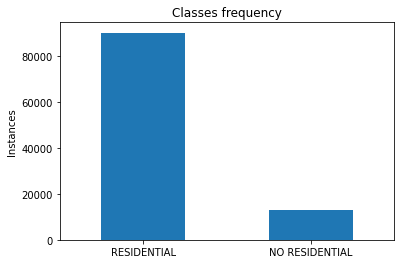

In [0]:
LABELS = ['RESIDENTIAL', 'NO RESIDENTIAL']

count_classes.plot(kind = 'bar', rot=0)
plt.xticks(range(2), LABELS)
plt.title('Classes frequency')
plt.ylabel('Instances');

Las características seleccionadas y empleadas por este primer modelo fueron seleccionadas y ajustadas de forma iterativa tras comprobar sus correspondientes relevancias en la predicción.

Características a utilizar por el modelo:

In [0]:
selected_features = [
  'mean_red', 'mean_green', 'mean_blue', 'mean_nir',
  'AREA',
  'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
  'CONTRUCTIONYEAR',
  'MAXBUILDINGFLOOR',
  'CADASTRALQUALITYID'
]

División del dataset en train / test equilibrando los valores de test:

In [0]:
train, test = train_test_split(df, test_size=0.30, stratify=df['RESIDENTIAL'])

counts_RESIDENTIAL = pd.value_counts(test.RESIDENTIAL, sort=True).array[0]
counts_NORESIDENTIAL = pd.value_counts(test.RESIDENTIAL, sort=True).array[1]

train_1 = test[test.RESIDENTIAL == 1].head(counts_RESIDENTIAL - counts_NORESIDENTIAL)
test_1 = test[test.RESIDENTIAL == 1].iloc[counts_RESIDENTIAL - counts_NORESIDENTIAL:]
test_0 = test[test.RESIDENTIAL == 0]

test = test_0.append(test_1)
train = train.append(train_1)

# Used later by model 2
train_backup = train

X_train = train[selected_features]
y_train = train['RESIDENTIAL']
X_test = test[selected_features]
y_test = test['RESIDENTIAL']

In [0]:
print('X_train: ', X_train.shape)
print('X_tests ', X_test.shape)
print('y_train: ', y_train.shape)
print('y_tests: ', y_test.shape)

X_train:  (95388, 12)
X_tests  (7822, 12)
y_train:  (95388,)
y_tests:  (7822,)


Aplicamos *oversampling* para balancear las clases:

In [0]:
ros = RandomOverSampler('minority', random_state=123)
X_train_res, y_train_res = ros.fit_sample(X_train, y_train)
 
print('Distribution before resampling {}'.format(Counter(y_train)))
print('Distribution after resampling {}'.format(Counter(y_train_res)))

Distribution before resampling Counter({1: 86262, 0: 9126})
Distribution after resampling Counter({1: 86262, 0: 86262})


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [0]:
print('X_train: ', X_train_res.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train_res.shape)
print('y_tests ', y_test.shape)

X_train:  (172524, 12)
X_test:  (7822, 12)
y_train:  (172524,)
y_tests  (7822,)


##3.2. **Parametrización**

Una vez preparados los datos, se llevó a cabo la parametrización (tuning) del modelo: un proceso iterativo que supuso un total de 7 horas de ejecución, permitiendo el ajuste de hiperparámetros a utilizar.

**(NO EJECUTAR)**

In [0]:
depth_range = sample(list(range(10,1000)), k=20) # Values for max_depth
min_samples_split_range = sample(list(range(4,300)), k=15) # Values for min_samples_split
min_samples_leaf_range = [1, 2, 4, 6, 8, 10, 15, 20, 25, 30] # Values for min_samples_leaf
criterion_range = ['gini', 'entropy']

# Best f1 for 0
param1 = {'criterion': None, 'depth': None, 'min_samples_split': None, 'min_samples_leaf': None}
bestF11 = 0.00

# Best f1 for 0 and 1
param2 = {'criterion': None, 'depth': None, 'min_samples_split': None, 'min_samples_leaf': None}
bestF120 = 0.00
bestF121 = 0.00

# Best recall for 0
param3 = {'criterion': None, 'depth': None, 'min_samples_split': None, 'min_samples_leaf': None}
bestRecall3 = 0.00

# Best recall for 0 and 1
param4 = {'criterion': None, 'depth': None, 'min_samples_split': None, 'min_samples_leaf': None}
bestRecall40 = 0.00
bestRecall41 = 0.00

# Best f1 for 0 and best acc
param5 = {'criterion': None, 'depth': None, 'min_samples_split': None, 'min_samples_leaf': None}
bestF150 = 0.00
bestAcc5 = 0.00

# Best recall for 0 and best acc
param6 = {'criterion': None, 'depth': None, 'min_samples_split': None, 'min_samples_leaf': None}
bestRecall60 = 0.00
bestAcc6 = 0.00

for depth in tqdm(depth_range):
    for min_samples_split in min_samples_split_range:
        for min_samples_leaf in min_samples_leaf_range:
            for criterion in criterion_range:
                tree_model = tree.DecisionTreeClassifier(criterion=criterion,
                                                 min_samples_split = min_samples_split,
                                                 min_samples_leaf = min_samples_leaf,
                                                 max_depth = depth
                                                )
      
                model = tree_model.fit( X = X_train_res, y = y_train_res)
                y_pred = model.predict(X_test)
                acc = accuracy_score(y_test, y_pred)
                f10 = precision_recall_fscore_support(y_test, y_pred, pos_label=0, average='binary')[2]
                f11 = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')[2]
                recall0 = precision_recall_fscore_support(y_test, y_pred, pos_label=0, average='binary')[1]
                recall1 = precision_recall_fscore_support(y_test, y_pred, pos_label=1, average='binary')[1]

                if(f10 > bestF11):
                    param1 = {'criterion': criterion, 'depth': depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
                    bestF11 = f10
                    
                if(f10 > bestF120 and f11 > bestF121):
                    param2 = {'criterion': criterion, 'depth': depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
                    bestF120 = f10
                    bestF121 = f11
                    
                if(recall0 > bestRecall3):
                    param3 = {'criterion': criterion, 'depth': depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
                    bestRecall3 = recall0
                    
                if(recall0 > bestRecall40 and recall1 > bestRecall41):
                    param4 = {'criterion': criterion, 'depth': depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
                    bestRecall40 = recall0
                    bestRecall41 = recall1
                    
                if(f10 > bestF150 and acc > bestAcc5):
                    param5 = {'criterion': criterion, 'depth': depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
                    bestF150 = f10
                    bestAcc5 = acc
                
                if(recall0 > bestRecall60 and acc > bestAcc6):
                    param6 = {'criterion': criterion, 'depth': depth, 'min_samples_split': min_samples_split, 'min_samples_leaf': min_samples_leaf}
                    bestRecall60 = recall0
                    bestAcc6 = acc
                    
    print(' ', end='\r')

print('Opcion1:\n', param1)
print('Opcion2:\n', param2)
print('Opcion3:\n', param3)
print('Opcion4:\n', param4)
print('Opcion5:\n', param5)
print('Opcion6:\n', param6)

##3.3. **Construcción del modelo y entrenamiento**

Construimos y entrenamos nuestro modelo (árbol de decisión):

In [0]:
MIN_SAMPLES_SPLIT = 120
MIN_SAMPLES_LEAF = 10
MAX_DEPTH = 412

CRITERION = 'gini'

In [0]:
clf = tree.DecisionTreeClassifier(criterion=CRITERION, 
                                  min_samples_split=MIN_SAMPLES_SPLIT, 
                                  min_samples_leaf=MIN_SAMPLES_LEAF, 
                                  max_depth=MAX_DEPTH)

clf.fit(X_train_res, y_train_res)

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=412, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=10, min_samples_split=120,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

Guardamos el modelo:

In [0]:
dump(clf, 'model1.joblib')

['model1.joblib']

##3.4. **Validación**

Finalmente, los resultados obtenidos por este primer modelo (tras múltiples ajustes, tanto de los hiperparámetros como de las características empleadas) alcanzaron un accuracy medio del 79%, obteniéndose los resultados mostrados en la matriz de confusión.


Predicción para los datos de validación (*test*):

In [0]:
y_pred = clf.predict(X_test[selected_features])

Relevancia de las características:

In [0]:
print("\n\nFeatures Relevance:\n")
print(pd.DataFrame({'Feature': selected_features, 'Relevancy': clf.feature_importances_}),"\n")
print("Maximum relevance RF :", max(clf.feature_importances_), "\n")



Features Relevance:

               Feature  Relevancy
0             mean_red   0.035148
1           mean_green   0.018442
2            mean_blue   0.053498
3             mean_nir   0.058047
4                 AREA   0.432016
5              GEOM_R1   0.059330
6              GEOM_R2   0.074430
7              GEOM_R3   0.041199
8              GEOM_R4   0.036252
9      CONTRUCTIONYEAR   0.063940
10    MAXBUILDINGFLOOR   0.081780
11  CADASTRALQUALITYID   0.045917 

Maximum relevance RF : 0.4320157500364351 



Matriz de confusión:

- `accuracy`: número total de predicciones correctas dividido por el número total de predicciones
- `precision`: define la fiabilidad de un modelo al responder si una instancia pertenece a cierta clase.
- `recall`: expresa cuan bien puede el modelo detectar una clase.
- `f1-score`: combinación de precisión y recall en una sola métrica.

In [0]:
LABELS = ['NO RESIDENTIAL', 'RESIDENTIAL']

def show_confusion_matrix(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y, normalize='true')
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True);
    plt.title('Confusion matrix')
    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test, pred_y))

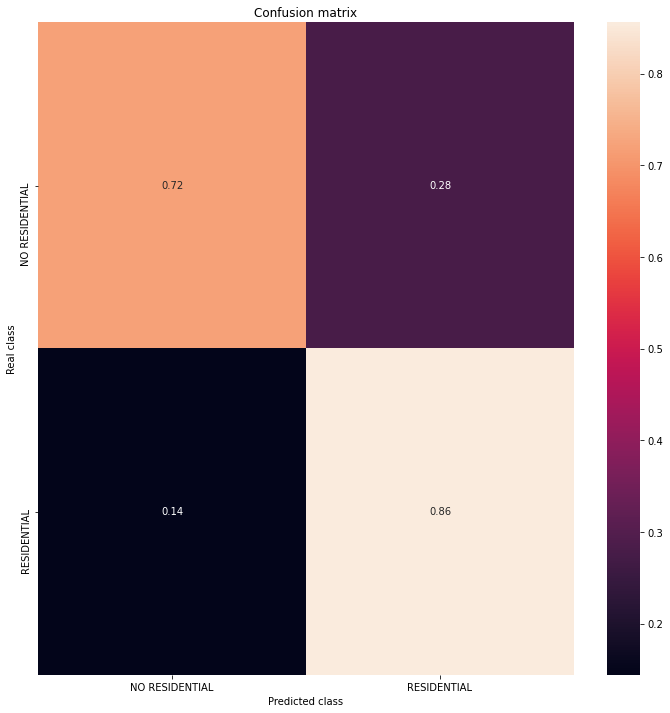

              precision    recall  f1-score   support

           0       0.83      0.72      0.77      3911
           1       0.75      0.86      0.80      3911

    accuracy                           0.79      7822
   macro avg       0.79      0.79      0.79      7822
weighted avg       0.79      0.79      0.79      7822



In [0]:
show_confusion_matrix(y_test, y_pred)

#4. **SEGUNDO MODELO: CLASIFICACIÓN DE NO RESIDENCIALES**

Una vez predicha la naturaleza residencial de nuestro conjunto de datos, se extrajo el conjunto de datos etiquetado como NO RESIDENCIAL, haciéndolo pasar por un segundo modelo de clasificación encargado de predecir de qué tipos de edificios no residenciales se trataban. 


## 4.1. **Preparación del nuevo dataset**

El segundo *dataframe* contendrá los edificios clasificados como NO RESIDENCIALES:

In [0]:
df2 = train_backup

df2['RESIDENTIAL_PREDICTED'] = clf.predict(df2[selected_features])

df2.drop(df2[df2.RESIDENTIAL_PREDICTED == 1].index, inplace=True)

df2

,X,Y,Q_R_4_0_0,Q_R_4_0_1,Q_R_4_0_2,Q_R_4_0_3,Q_R_4_0_4,Q_R_4_0_5,Q_R_4_0_6,Q_R_4_0_7,Q_R_4_0_8,Q_R_4_0_9,Q_R_4_1_0,Q_G_3_0_0,Q_G_3_0_1,Q_G_3_0_2,Q_G_3_0_3,Q_G_3_0_4,Q_G_3_0_5,Q_G_3_0_6,Q_G_3_0_7,Q_G_3_0_8,Q_G_3_0_9,Q_G_3_1_0,Q_B_2_0_0,Q_B_2_0_1,Q_B_2_0_2,Q_B_2_0_3,Q_B_2_0_4,Q_B_2_0_5,Q_B_2_0_6,Q_B_2_0_7,Q_B_2_0_8,Q_B_2_0_9,Q_B_2_1_0,Q_NIR_8_0_0,Q_NIR_8_0_1,Q_NIR_8_0_2,Q_NIR_8_0_3,Q_NIR_8_0_4,Q_NIR_8_0_5,Q_NIR_8_0_6,Q_NIR_8_0_7,Q_NIR_8_0_8,Q_NIR_8_0_9,Q_NIR_8_1_0,AREA,GEOM_R1,GEOM_R2,GEOM_R3,GEOM_R4,CONTRUCTIONYEAR,MAXBUILDINGFLOOR,CADASTRALQUALITYID,CLASE,mean_red,mean_green,mean_blue,mean_nir,std_red,std_green,std_blue,std_nir,max_red,max_green,max_blue,max_nir,min_red,min_green,min_blue,min_nir,RESIDENTIAL,RESIDENTIAL_PREDICTED
56764,2169044819,165462057,3.225805e-10,386.998962,543.007788,656.000073,773.999634,895.998505,1029.996167,1209.001526,1448.995605,1837.001917,5925.849598,5.348288e-11,387.999829,503.999951,592.002527,678.798962,770.997833,873.998938,1004.001697,1184.004907,1494.297144,5666.722884,82.000023,301.999908,361.999969,421.999878,481.999939,544.000671,601.000000,666.000061,732.000061,905.001575,2316.603431,1.416269e-03,1111.003467,1410.999243,1619.000977,1776.001807,1921.999817,2068.997021,2249.002563,2469.597461,2820.002173,6351.600628,30.864210,0.551487,0.138112,0.129374,0.936736,1971,5,6,6,1336.986343,1196.074970,674.055047,2163.473325,1603.946002,1535.972564,588.534171,1579.265904,5925.849598,5666.722884,2316.603431,6351.600628,3.225805e-10,5.348288e-11,82.000023,1.416269e-03,0,0
86474,2197290923,165446371,2.751640e-11,397.001868,580.999023,726.002234,854.014478,981.002075,1119.000879,1264.998499,1454.006982,1753.997083,4630.129266,2.994482e-06,363.002579,497.001849,597.001514,682.998462,767.000488,851.998999,948.997882,1076.995190,1296.996497,4844.087215,179.000473,409.999908,452.000000,481.000000,509.000153,536.000061,563.999939,591.999579,625.000000,683.999817,1235.348682,2.170863e-11,696.003888,972.004810,1181.000183,1356.993457,1541.000610,1728.996118,1949.997009,2212.995947,2599.996533,5404.656680,1417.614898,0.735859,0.034892,0.014877,0.426357,1999,6,4,5,1251.013853,1084.189153,569.758965,1785.785930,1223.915290,1295.902799,257.765748,1400.725091,4630.129266,4844.087215,1235.348682,5404.656680,2.751640e-11,2.994482e-06,179.000473,2.170863e-11,1,0
76197,2221513359,165629631,0.000000e+00,316.997635,503.003845,655.999390,798.997314,941.999359,1097.001221,1271.008667,1485.996460,1809.992981,5128.239982,0.000000e+00,286.001678,436.001587,551.001312,650.002014,745.003143,841.999146,954.994141,1102.000244,1357.000916,5394.218264,150.000244,399.999649,458.000092,500.000061,533.999878,569.000122,603.999939,642.999969,691.999878,759.999939,1577.964650,3.086397e-12,534.996429,808.998047,1023.002960,1200.996460,1381.002197,1568.003296,1766.001709,1998.009033,2347.998413,5448.082132,235.946095,0.489131,0.032776,0.063249,1.929730,1965,13,5,5,1273.566987,1119.838404,626.178584,1643.371880,1380.937131,1467.413834,355.357032,1428.059631,5128.239982,5394.218264,1577.964650,5448.082132,0.000000e+00,0.000000e+00,150.000244,3.086397e-12,1,0
62897,2191418770,165797396,0.000000e+00,325.001498,513.997632,659.003906,794.994531,920.503754,1056.002026,1207.999463,1411.999243,1750.692944,6132.774465,0.000000e+00,303.001892,460.000610,575.999731,672.001331,767.002167,864.999780,978.998969,1131.002905,1394.694458,6214.232925,145.000366,418.000192,472.999762,512.000549,542.000391,573.000000,601.999438,635.000677,686.000061,765.999921,2273.371104,6.377375e-07,579.005695,881.006104,1130.997937,1344.999683,1541.997131,1729.991431,1929.994458,2191.001807,2586.998071,6249.828995,27.516450,0.816221,0.232558,0.127551,0.548469,1993,1,3,5,1342.997224,1214.721343,693.215678,1833.256483,1663.952687,1702.695857,548.533099,1639.493571,6132.774465,6214.232925,2273.371104,6249.828995,0.000000e+00,0.000000e+00,145.000366,6.377375e-07,1,0
44222,2204971536,165533795,7.752092e-11,451.006500,635.998413,791.011017,941.994141,1077.501160,1215.999268

Al igual que en el caso anterior, las características empleadas por el modelo fueron consideradas basándonos en su relevancia a la hora de predecir los datos de validación. 

Selección de características para el segundo modelo:

In [0]:
selected_features_2 = [
  'X','Y',
  'max_red', 'max_green', 'max_blue', 'max_nir',
  'AREA',
  'GEOM_R1', 'GEOM_R2', 'GEOM_R3', 'GEOM_R4',
  'CONTRUCTIONYEAR',
  'MAXBUILDINGFLOOR',
  'CADASTRALQUALITYID'
]

## 4.2. **Separación en Train y Test**

División del dataset en *train* y *test*:

In [0]:
X = df2[selected_features_2]
y = df2['CLASE']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.20, stratify=df2['CLASE'])

In [0]:
print('X_train: ', X_train_res.shape)
print('X_test: ', X_test.shape)
print('y_train: ', y_train_res.shape)
print('y_tests ', y_test.shape)

X_train:  (172524, 12)
X_test:  (3838, 14)
y_train:  (172524,)
y_tests  (3838,)


## 4.3. **Parametrización**

También se llevó a cabo un proceso de parametrización similar al anterior, adecuado a los hiperparámetros de los random forests, esta vez con una duración de aproximadamente 10 horas. 


**(NO EJECUTAR)**

Parametrización del modelo (Random Forest):

In [0]:
PARAM_DIST = {"n_estimators": [4, 8, 16, 32, 64, 128, 256, 512],
              "max_features": ['auto', 'sqrt'], # Number of features to consider at every split
              "max_depth": [10,9,8,7,6,5,4,3,2,None], # Maximum number of levels in tree
              "min_samples_split": sp_randint(2, 50), #  Minimum number of samples required to split a node
              "min_samples_leaf": sp_randint(1, 50), # Minimum number of samples required at each leaf node
              "bootstrap": [True, False], # Method of selecting samples for training each tree
              "criterion": ["gini", "entropy"]}

N_ITER = 250
N_FOLDS = 6

In [0]:
clf = RandomForestClassifier(random_state=0)

random_search = RandomizedSearchCV(clf, scoring= 'accuracy', 
                                   param_distributions=PARAM_DIST, 
                                   n_iter=N_ITER, cv=N_FOLDS)
                                   

random_search.fit(X_train, y_train)

In [0]:
def report(results, n_top=20):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")
            
report(random_search.cv_results_)

## 4.4. **Construcción del modelo y entrenamiento**

Construimos el segundo modelo (*Random Forest*):

In [0]:
N_ESTIMATORS = 128
CRITERION = 'entropy'
MAX_DEPTH = None
MAX_FEATURES = 'sqrt'
MIN_SAMPLES_LEAF = 1
MIN_SAMPLES_SPLIT = 5
BOOTSTRAP = True
CLASS_WEIGHT = 'balanced'

In [0]:
clf = RandomForestClassifier(n_estimators=N_ESTIMATORS, criterion=CRITERION, 
                                max_depth=MAX_DEPTH, max_features=MAX_FEATURES, 
                                min_samples_leaf=MIN_SAMPLES_LEAF, 
                                min_samples_split=MIN_SAMPLES_SPLIT,
                                bootstrap=BOOTSTRAP, n_jobs=-1, 
                                class_weight=CLASS_WEIGHT)

clf.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight='balanced',
                       criterion='entropy', max_depth=None, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=128,
                       n_jobs=-1, oob_score=False, random_state=None, verbose=0,
                       warm_start=False)

Guardamos el modelo:

In [0]:
dump(clf, 'model2.joblib')

['model2.joblib']

## 4.5. **Validación**

Tras el entrenamiento, esta vez utilizando validación cruzada, los resultados obtenidos en esta clasificación multiclase fueron los detallados en la matriz de confusión correspondiente.


Predicción para los datos de validación (*test*):

In [0]:
y_pred = clf.predict(X_test)

Relevancia de las características:

In [0]:
def print_full(x):
    pd.set_option('display.max_rows', len(x))
    print(x)
    pd.reset_option('display.max_rows')

print("\n\nFeatures Relevance:\n")
print_full(pd.DataFrame({'Feature': selected_features_2, 'Relevancy': clf.feature_importances_}))
print("Maximum relevance RF :", max(clf.feature_importances_), "\n")



Feature Relevance:

               Feature  Relevancy
0                    X   0.104770
1                    Y   0.120964
2              max_red   0.056641
3            max_green   0.060812
4             max_blue   0.051613
5              max_nir   0.048406
6                 AREA   0.084987
7              GEOM_R1   0.103631
8              GEOM_R2   0.072410
9              GEOM_R3   0.074273
10             GEOM_R4   0.053130
11     CONTRUCTIONYEAR   0.064426
12    MAXBUILDINGFLOOR   0.064207
13  CADASTRALQUALITYID   0.039729
Maximum relevance RF : 0.12096386279184397 



Matriz de cofusión:

In [0]:
LABELS = ['AGRICULTURE', 'INDUSTRIAL', 'OFFICE', 'OTHER', 'PUBLIC', 'RESIDENTIAL', 'RETAIL']

def show_confusion_matrix(y_test, pred_y):
    conf_matrix = confusion_matrix(y_test, pred_y, normalize='true')
    plt.figure(figsize=(12, 12))
    sns.heatmap(conf_matrix, xticklabels=LABELS, yticklabels=LABELS, annot=True);
    plt.title('Confusion matrix')
    plt.ylabel('Real class')
    plt.xlabel('Predicted class')
    plt.show()
    print(classification_report(y_test, pred_y))

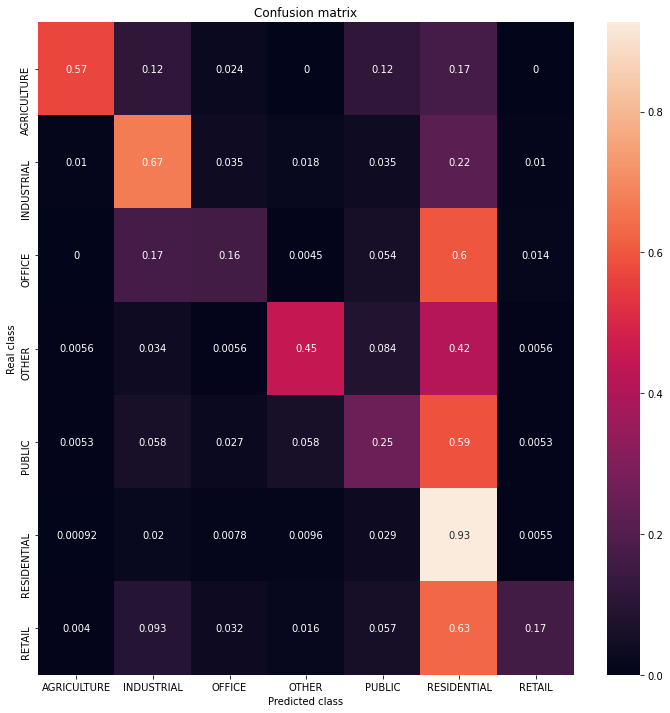

              precision    recall  f1-score   support

           0       0.67      0.57      0.62        42
           1       0.74      0.67      0.71       595
           2       0.38      0.16      0.23       221
           3       0.58      0.45      0.50       178
           4       0.42      0.25      0.32       377
           5       0.74      0.93      0.82      2178
           6       0.63      0.17      0.26       247

    accuracy                           0.70      3838
   macro avg       0.59      0.46      0.49      3838
weighted avg       0.67      0.70      0.67      3838



In [0]:
show_confusion_matrix(y_test, y_pred)